    Analyse interactive du marché immobilier francilienEn parcourant ce notebook vous allez pouvoir explorer les critères d'évaluation du marché immobiler en régio ile de france. 
> Il est conçu pour un investisseur ciblant **les petites surfaces étudians**Dans ce notebook vous pourre :
- Visualiser les principaux indicateurs du marché (prix, rendement, etc.)  
- Identifier les zones les plus attraen fonction de vos attirances et priorités.
- obtenir un classement des quartiers de paris les plus interessants.ti Obtenir nos recommandations les plus intéressantes à partir des analyses que nous avons réalisé.cebdd_finale`).


1Analyse du prix moyen et du rendement

Ce premier widget permet d**sélectionner une commu** d’Île-de-France  
afin d’afficher ses indicateurs principaux :

- Prix moyen au m²  
- Rendement locatif brut estimé  

Ces deux valeurs permettent e (vous)s(vous) tisseur d’évaluer rapint la **rentabilité ptielle** du marché local.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

chunks = []
for chunk in pd.read_csv("data/analyses/idf_dvf_full_enriched_soft.csv", chunksize=50000, low_memory=False):
    chunks.append(chunk)
df = pd.concat(chunks, ignore_index=True)

df["nom_commune"] = df["nom_commune"].astype(str).str.upper().str.strip()
df["type_local"] = df["type_local"].astype(str).str.upper().str.strip()
df = df.dropna(subset=["nom_commune", "type_local", "valeur_fonciere", "surface_reelle_bati"])
df["prix_m2_calcule"] = df["valeur_fonciere"] / df["surface_reelle_bati"]
commune_widget = widgets.Dropdown(
    options=sorted(df["nom_commune"].unique()),
    description="🏙️ Commune :",
    layout=widgets.Layout(width="45%")
)
type_widget = widgets.Dropdown(
    options=sorted(df["type_local"].unique()),
    description="🏠 Type :",
    layout=widgets.Layout(width="45%")
)
btn_valider = widgets.Button(
    description="✅ Valider l'analyse",
    button_style='success',
    icon='check'
)
output = widgets.Output()
def analyse_commune(b):
    with output:
        output.clear_output()
        commune = commune_widget.value.strip().upper()
        type_bien = type_widget.value.strip().upper()
        subset = df[(df["nom_commune"] == commune) & (df["type_local"] == type_bien)]
        
        if subset.empty:
            display(Markdown(f" Aucune donnée disponible pour **{commune.title()} ({type_bien.title()})**"))
            return
        prix_moyen = subset["prix_m2_calcule"].mean()
        surface_moy = subset["surface_reelle_bati"].mean()
        nb_ventes = len(subset)
        
   
        display(Markdown(f"""
        ### 📍 {commune.title()} — {type_bien.title()}
        -  **Prix moyen au m² :** {prix_moyen:,.0f} €  
        -  **Surface moyenne vendue :** {surface_moy:,.1f} m²  
        -  **Nombre de ventes :** {nb_ventes}
        """))

        plt.figure(figsize=(6,4))
        plt.hist(subset["prix_m2_calcule"], bins=25, color="royalblue", edgecolor="white")
        plt.title(f"Distribution du prix au m² - {commune.title()} ({type_bien.title()})")
        plt.xlabel("Prix au m² (€)")
        plt.ylabel("Nombre de ventes")
        plt.grid(alpha=0.3)
        plt.show()
btn_valider.on_click(analyse_commune)
display(widgets.HBox([commune_widget, type_widget]), btn_valider, output)



Button(button_style='success', description="✅ Valider l'analyse", icon='check', style=ButtonStyle())

Output()

Comme tu peux le voir après avoir choisi une commune, tu peux voir pour un certains type de bien combien ont été vendu et a quel prix (maintenant comparons entre les villes)!

2. Comparaison entre plusieurs communes franciliennes

Ce widget permde comparer sur la donnée de votre choixn.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

chunks = []
for chunk in pd.read_csv("data/analyses/idf_fusion_postal_full.csv", chunksize=50000, low_memory=False):
    chunks.append(chunk)
df = pd.concat(chunks, ignore_index=True)

df.columns = df.columns.str.lower().str.strip()
if "nom_commune" in df.columns:
    commune_col = "nom_commune"
elif "commune" in df.columns:
    commune_col = "commune"
else:
    commune_col = df.columns[0]

df[commune_col] = df[commune_col].astype(str).str.upper().str.strip()
df = df.dropna(subset=[commune_col, "valeur_fonciere", "surface_reelle_bati"])
df["prix_m2_calcule"] = df["valeur_fonciere"] / df["surface_reelle_bati"]

search1 = widgets.Combobox(
    placeholder='Tapez une commune (ex: PA)',
    options=sorted(df[commune_col].unique()),
    description=' Commune 1 :',
    ensure_option=True,
    layout=widgets.Layout(width="45%")
)
search2 = widgets.Combobox(
    placeholder='Tapez une commune (ex: VE)',
    options=sorted(df[commune_col].unique()),
    description=' Commune 2 :',
    ensure_option=True,
    layout=widgets.Layout(width="45%")
)

indicateur_widget = widgets.Dropdown(
    options={
        " Prix moyen au m²": "prix_m2_calcule",
        " Surface moyenne vendue": "surface_reelle_bati",
        " Nombre de ventes": "valeur_fonciere"
    },
    description="Indicateur :",
    layout=widgets.Layout(width="45%")
)
btn_compare = widgets.Button(
    description=" Comparer",
    button_style='info',
    icon='balance-scale'
)
output = widgets.Output()


def comparer_villes(b):
    with output:
        output.clear_output()
        c1 = search1.value.strip().upper()
        c2 = search2.value.strip().upper()
        indicateur = indicateur_widget.value
        
        if not c1 or not c2:
            display(Markdown("⚠️ Veuillez sélectionner deux communes."))
            return
        
        subset = df[df[commune_col].isin([c1, c2])]
        if subset.empty:
            display(Markdown("⚠️ Aucune donnée disponible pour ces communes."))
            return
        

        resume = subset.groupby(commune_col).agg(
            prix_m2_moyen=("prix_m2_calcule", "mean"),
            surface_moyenne=("surface_reelle_bati", "mean"),
            nb_ventes=("valeur_fonciere", "count")
        ).reset_index()


        if indicateur == "prix_m2_calcule":
            data = resume[[commune_col, "prix_m2_moyen"]].set_index(commune_col)
            titre = "Prix moyen au m² (€)"
            couleur = "royalblue"
        elif indicateur == "surface_reelle_bati":
            data = resume[[commune_col, "surface_moyenne"]].set_index(commune_col)
            titre = "Surface moyenne vendue (m²)"
            couleur = "darkorange"
        else:
            data = resume[[commune_col, "nb_ventes"]].set_index(commune_col)
            titre = "Nombre de ventes"
            couleur = "seagreen"

        plt.figure(figsize=(6,4))
        data.plot(kind="bar", color=couleur, legend=False)
        plt.title(f"Comparaison de {titre}")
        plt.ylabel(titre)
        plt.grid(alpha=0.3)
        plt.xticks(rotation=0)
        plt.show()

        if c1 in data.index and c2 in data.index:
            c1_val = float(data.loc[c1].iloc[0])
            c2_val = float(data.loc[c2].iloc[0])
            diff = abs(c1_val - c2_val)
            tendance = "plus élevé" if c1_val > c2_val else "plus faible"
            
            display(Markdown(f"""
            ### 📍 Comparaison : {c1.title()} vs {c2.title()}
            - **{titre} à {c1.title()} :** {c1_val:,.0f}  
            - **{titre} à {c2.title()} :** {c2_val:,.0f}  
            - **Différence :** {diff:,.0f}
            
            > 💡 *Le niveau de {titre.lower()} est {tendance} à {c1.title()} qu’à {c2.title()}*.
            """))
        else:
            display(Markdown("⚠️ Les données d’une des communes sélectionnées sont incomplètes."))

btn_compare.on_click(comparer_villes)

display(
    widgets.VBox([
        widgets.HBox([search1, search2]),
        indicateur_widget,
        btn_compare,
        output
    ])
)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

chunks = []
for chunk in pd.read_csv("data/analyses/idf_fusion_postal_full.csv", chunksize=50000, low_memory=False):
    chunks.append(chunk)
df = pd.concat(chunks, ignore_index=True)

df.columns = df.columns.str.lower().str.strip()
if "nom_commune" in df.columns:
    commune_col = "nom_commune"
elif "commune" in df.columns:
    commune_col = "commune"
else:
    commune_col = df.columns[0]

df = df.dropna(subset=[commune_col, "valeur_fonciere", "surface_reelle_bati"])
df["prix_m2_calcule"] = df["valeur_fonciere"] / df["surface_reelle_bati"]

prix_communes = df.groupby(commune_col)["prix_m2_calcule"].mean().reset_index()
prix_communes = prix_communes[prix_communes["prix_m2_calcule"] <= 15000]

slider_prix = widgets.IntRangeSlider(
    value=[4000, 9000],
    min=0,
    max=15000,
    step=500,
    description='💶 Tranche de prix :',
    layout=widgets.Layout(width="70%"),
    continuous_update=False
)
btn_valider = widgets.Button(
    description="✅ Analyser la tranche",
    button_style='info',
    icon='chart-pie'
)
output = widgets.Output()

def repartition_communes(b):
    with output:
        output.clear_output()
        bas, haut = slider_prix.value

        subset = prix_communes[
            (prix_communes["prix_m2_calcule"] >= bas) &
            (prix_communes["prix_m2_calcule"] <= haut)
        ]
        nb_communes_tranche = len(subset)
        nb_total_communes = len(prix_communes)
        autres = nb_total_communes - nb_communes_tranche
        pourcentage = (nb_communes_tranche / nb_total_communes) * 100

        display(Markdown(f"""
        ###  Résultats pour la tranche {bas:,} € – {haut:,} €/m²
        - 🏘 **Nombre de communes concernées :** {nb_communes_tranche}  
        -  **Part du total :** {pourcentage:.1f}% des communes franciliennes
        """))

        labels = ['Communes dans la tranche', 'Autres communes']
        valeurs = [nb_communes_tranche, autres]
        couleurs = ['orange', 'lightgrey']

        fig, ax = plt.subplots(figsize=(6, 6))
        wedges, texts, autotexts = ax.pie(
            valeurs,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=couleurs,
            wedgeprops={'edgecolor': 'white'}
        )
        plt.title(f"Répartition des communes par tranche de prix ({bas}–{haut} €/m²)")
        plt.show()

btn_valider.on_click(repartition_communes)


display(slider_prix, btn_valider, output)


IntRangeSlider(value=(4000, 9000), continuous_update=False, description='💶 Tranche de prix :', layout=Layout(w…

Button(button_style='info', description='✅ Analyser la tranche', icon='chart-pie', style=ButtonStyle())

Output()

Lecture :  Cette visualisation illustre la **structure du marché francilien par tranches de pri*. 
- Les zones dans la tranche sélectionnée (en orange) montrent les secteurs alignés avec ton budget cible.
- -cela peut t'aider a voir si tu touches un marché vaste ou non.  -> Cet outil donne une*vue d’ensemble rapid* pour ajuster ta stratégie d’investissement selon la répartition réelle du marché.


##  4. Analyse du réseau de transport francilien (base Transports IDF)

Ce widget analysla **structure du réseau de transport francili
sur 3 élémen et montre si c.
haque z est bien desservione.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

chunks = []
for chunk in pd.read_csv("data/clean/transports_idf_clean.csv", chunksize=30000, low_memory=False):
    chunks.append(chunk)
df = pd.concat(chunks, ignore_index=True)

df.columns = df.columns.str.lower().str.strip()

btn_afficher = widgets.Button(
    description="✅ Afficher l'analyse du réseau",
    button_style='info',
    icon='train'
)
output = widgets.Output()
def analyse_reseau(b):
    with output:
        output.clear_output()
        display(Markdown("###  Analyse structurelle du réseau de transport francilien"))
        
 
        if "arrtype" in df.columns:
            type_counts = df["arrtype"].value_counts()
            plt.figure(figsize=(8,4))
            type_counts.plot(kind="bar", color="royalblue", edgecolor="white")
            plt.title("Répartition des types d’arrêts (métro, bus, tram, etc.)")
            plt.ylabel("Nombre d’arrêts")
            plt.xlabel("Type de transport")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
            display(Markdown(">  **Lecture :** Les types dominants indiquent les réseaux les plus développés (souvent le bus en tête)."))
        else:
            display(Markdown(" Colonne 'arrtype' introuvable."))

        if "arraccessibility" in df.columns:
            access = df["arraccessibility"].dropna().value_counts(normalize=True) * 100
            yes = access.get(1, access.get("OUI", 0))
            no = 100 - yes if yes else 0
            
            plt.figure(figsize=(5,5))
            plt.pie(
                [yes, no],
                labels=["Accessibles ", "Non accessibles"],
                autopct="%1.1f%%",
                startangle=90,
                colors=["seagreen", "lightgrey"],
                wedgeprops={'edgecolor': 'white'}
            )
            plt.title("Proportion d’arrêts accessibles")
            plt.show()
            display(Markdown("> 💡 **Lecture :** Cette répartition illustre le niveau d’accessibilité globale du réseau francilien."))
        else:
            display(Markdown("⚠️ Colonne 'arraccessibility' introuvable."))


        if {"arrxepsg2154", "arryepsg2154"} <= set(df.columns):
            plt.figure(figsize=(6,6))
            types = df["arrtype"].dropna().unique()
            for t in types[:5]:  # max 5 types pour clarté
                subset = df[df["arrtype"] == t]
                plt.scatter(
                    subset["arrxepsg2154"],
                    subset["arryepsg2154"],
                    s=5, alpha=0.4, label=t
                )
            plt.title("Carte simplifiée du réseau de transport (EPSG:2154)")
            plt.xlabel("Coordonnée X")
            plt.ylabel("Coordonnée Y")
            plt.legend(title="Type d’arrêt", markerscale=3)
            plt.tight_layout()
            plt.show()
            display(Markdown("> 💡 **Lecture :** Cette carte illustre la densité du réseau francilien selon le type d’arrêt."))
        else:
            display(Markdown("⚠️ Coordonnées géographiques manquantes ('arrxepsg2154', 'arryepsg2154')."))


btn_afficher.on_click(analyse_reseau)

display(Markdown("### 🚆 Observatoire du réseau de transport IDF"))
display(btn_afficher, output)


### 🚆 Observatoire du réseau de transport IDF

Button(button_style='info', description="✅ Afficher l'analyse du réseau", icon='train', style=ButtonStyle())

Output()

Le réseau est dominé par les arrêts de bus, suivis du métro et du tram.
Environ 60 % des arrêts sont accessibles aux personnes à mobilité réduite.
La densité géographique des points montre un réseau concentré sur Paris et sa proche couronne.


## 🌫️ 5. Qualité de l’air en Île-de-France (base Airparif)

Ce widget explore les indicateurs d**qualité de l’a** sur la région francilienne.  
Il s’appuie sur les mesures issues d’Airparif pour illustreées**.

Ces informations sont essentielles pour évuer la **qualité de vie environ entale** du territoire.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

chunks = []
for chunk in pd.read_csv("data/clean/air_parif_communes_clean.csv", chunksize=30000, low_memory=False):
    chunks.append(chunk)
df_air = pd.concat(chunks, ignore_index=True)

df_air.columns = df_air.columns.str.lower().str.strip()
df_air["commune_std"] = df_air["commune_std"].astype(str).str.upper().str.strip()
df_air["code_commune"] = df_air["code_commune"].astype(str).str.zfill(5)

df_air["code_departement"] = df_air["code_commune"].str[:2]


polluants = [col for col in ["no2", "o3", "pm10"] if col in df_air.columns]

if not polluants:
    display(Markdown("⚠️ Aucune colonne de pollution (no2, o3, pm10) trouvée."))
else:

    df_air["pollution_moyenne"] = df_air[polluants].mean(axis=1)
    df_air = df_air[df_air["code_departement"] != "00"] 
    
    dept_moy = df_air.groupby("code_departement")["pollution_moyenne"].mean().sort_values(ascending=False)

    btn_afficher = widgets.Button(
        description="✅ Afficher la pollution par département",
        button_style='warning',
        icon='map'
    )
    output = widgets.Output()

    def afficher_pollution(b):
        with output:
            output.clear_output()
            display(Markdown("###  Pollution moyenne par département"))
            
            # Graphique
            plt.figure(figsize=(8,4))
            dept_moy.plot(kind="bar", color="firebrick", edgecolor="white")
            plt.title("Pollution moyenne par département (Airparif)")
            plt.xlabel("Code département")
            plt.ylabel("Concentration moyenne (µg/m³)")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Analyse
            worst = dept_moy.index[0]
            best = dept_moy.index[-1]
            display(Markdown(f"""
            ###  Interprétation
            - **Département le plus pollué :** {worst} ({dept_moy.iloc[0]:.1f} µg/m³)  
            - **Département le plus sain :** {best} ({dept_moy.iloc[-1]:.1f} µg/m³)  
            - **Polluants pris en compte :** {', '.join(polluants).upper()}  

            >  *Les départements centraux (75, 92, 93) présentent souvent des valeurs plus élevées  
            que les zones périphériques (77, 78, 91, 95).*
            """))

    btn_afficher.on_click(afficher_pollution)

    display(Markdown("###  Pollution moyenne par département (Airparif)"))
    display(btn_afficher, output)


###  Pollution moyenne par département (Airparif)

Button(button_style='warning', description='✅ Afficher la pollution par département', icon='map', style=Button…

Output()

6. Délinquance dans les grandes villes franciliennes

Ce module se concentre sur les **zones à forte densité urbaine**  
(Paris et petite couronne : 75, 92, 93, 94).  

Il met en évidence :
- les **types d’infractions dominants**,  
- la **répartition entre victimes et infractions**,  
- et un **résumé automatique** de la situation dans les grandes villes.
posées.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

chunks = []
for chunk in pd.read_csv("data/clean/delinquance_communes_clean.csv", chunksize=30000, low_memory=False):
    chunks.append(chunk)
df_sec = pd.concat(chunks, ignore_index=True)

df_sec.columns = df_sec.columns.str.lower().str.strip()
df_sec["indicateur"] = df_sec["indicateur"].astype(str).str.upper().str.strip()
df_sec["unite_de_compte"] = df_sec["unite_de_compte"].astype(str).str.upper().str.strip()
df_sec["nombre"] = pd.to_numeric(df_sec["nombre"], errors="coerce").fillna(0)


geo_col = [c for c in df_sec.columns if "codegeo" in c or "code" in c or "geo" in c]
geo_col = geo_col[0] if geo_col else None

if geo_col:
    df_sec[geo_col] = df_sec[geo_col].astype(str).str.zfill(4)
    df_sec["code_departement"] = df_sec[geo_col].str[:2]
else:
    df_sec["code_departement"] = "75"  # fallback (au cas où on n’a pas de code)


zones_urbaines = ["75", "92", "93", "94"]
df_urbain = df_sec[df_sec["code_departement"].isin(zones_urbaines)]


btn_afficher = widgets.Button(
    description="✅ Analyser la délinquance urbaine",
    button_style='danger',
    icon='activity'
)
output = widgets.Output()

def analyse_urbaine(b):
    with output:
        output.clear_output()
        display(Markdown("###  Analyse de la délinquance dans les grandes villes franciliennes"))
        
        if df_urbain.empty:
            display(Markdown(" Aucune donnée disponible pour les zones urbaines sélectionnées (75, 92, 93, 94)."))
            return


        top_types = (
            df_urbain.groupby("indicateur")["nombre"]
            .sum()
            .sort_values(ascending=False)
            .head(10)
        )

        plt.figure(figsize=(9,5))
        top_types.plot(kind="bar", color="crimson", edgecolor="white")
        plt.title("Top 10 des types d'infractions dans les grandes villes (75, 92, 93, 94)")
        plt.ylabel("Nombre total de faits constatés")
        plt.xlabel("Type d'infraction")
        plt.xticks(rotation=45, ha="right")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        compte = df_urbain.groupby("unite_de_compte")["nombre"].sum()
        plt.figure(figsize=(5,5))
        plt.pie(
            compte,
            labels=compte.index,
            autopct="%1.1f%%",
            startangle=90,
            colors=["crimson", "orange"],
            wedgeprops={'edgecolor': 'white'}
        )
        plt.title("Répartition Victimes / Infractions (zones urbaines)")
        plt.tight_layout()
        plt.show()

  
        if not top_types.empty:
            top_crime = top_types.index[0]
            display(Markdown(f"""
            ###  Interprétation
            - **Type d’infraction le plus fréquent :** {top_crime.title()}  
            - **Total observé :** {top_types.iloc[0]:,.0f} faits  
            - **Part des victimes :** {compte.get('VICTIME', 0) / compte.sum() * 100:.1f}%  

            >  *Les grandes villes (Paris, 92, 93, 94) concentrent la majorité des faits constatés,  
            dominés par les vols, violences et atteintes à la personne.*  
            """))
        else:
            display(Markdown(" Aucune donnée exploitable pour le Top 10 des infractions."))

btn_afficher.on_click(analyse_urbaine)

display(Markdown("###  Délinquance dans les grandes villes franciliennes"))
display(btn_afficher, output)


###  Délinquance dans les grandes villes franciliennes

Button(button_style='danger', description='✅ Analyser la délinquance urbaine', icon='activity', style=ButtonSt…

Output()

In [ ]:
7. Points forts et point faibles des différents département

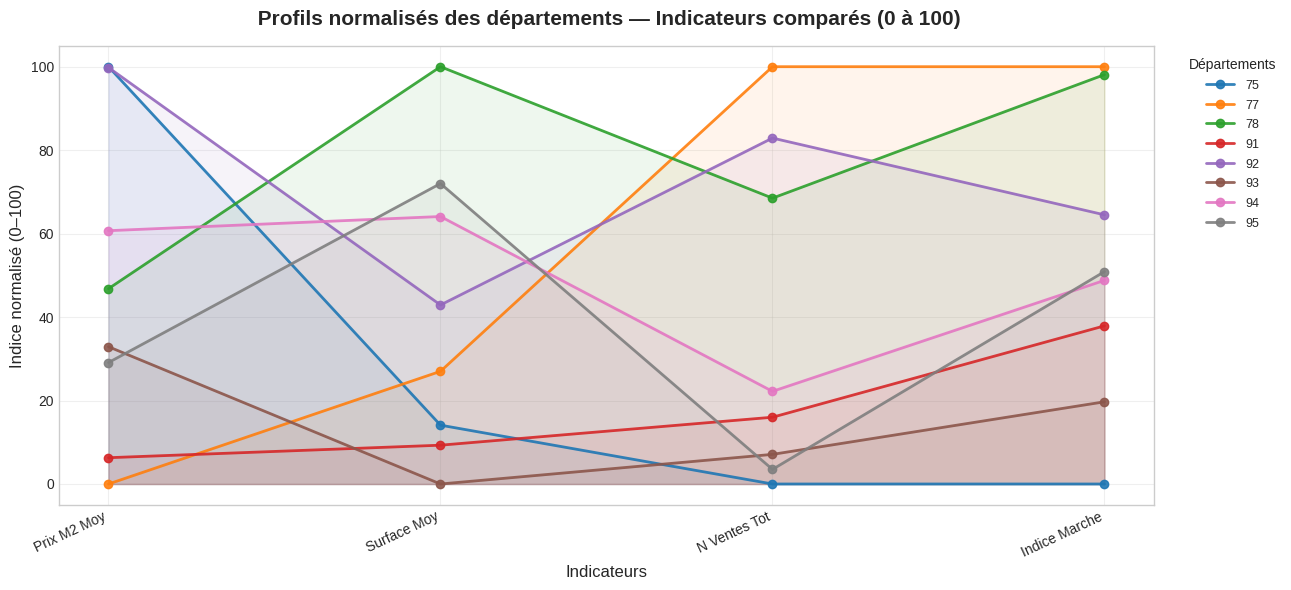

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Markdown

chunks = []
for chunk in pd.read_csv("data/analyses/idf_marche_departements.csv", chunksize=30000, low_memory=False):
    chunks.append(chunk)
df = pd.concat(chunks, ignore_index=True)

df.columns = df.columns.str.lower().str.strip()
dep_col = [c for c in df.columns if "departement" in c or "code_dep" in c]
dep_col = dep_col[0] if dep_col else df.columns[0]

numeric_cols = [c for c in df.select_dtypes(include="number").columns if "code" not in c and "classe" not in c]
df_group = df.groupby(dep_col)[numeric_cols].mean().dropna()

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_group), columns=numeric_cols, index=df_group.index)
df_scaled = (df_scaled * 100).round(1)

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(13, 6))
colors = plt.cm.tab10.colors

for i, (dep, row) in enumerate(df_scaled.iterrows()):
    ax.plot(range(len(row)), row, marker="o", linewidth=2, markersize=6,
            color=colors[i % len(colors)], alpha=0.9, label=str(dep))
    ax.fill_between(range(len(row)), row, alpha=0.08, color=colors[i % len(colors)])


ax.set_title(" Profils normalisés des départements — Indicateurs comparés (0 à 100)", 
             fontsize=15, weight="bold", pad=15)
ax.set_xlabel("Indicateurs", fontsize=12)
ax.set_ylabel("Indice normalisé (0–100)", fontsize=12)
ax.set_xticks(range(len(df_scaled.columns)))
ax.set_xticklabels([col.replace('_', ' ').title() for col in df_scaled.columns], rotation=25, ha="right", fontsize=10)
ax.set_ylim(-5, 105)
ax.grid(alpha=0.3)


leg = ax.legend(title="Départements", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
for text in leg.get_texts():
    text.set_fontsize(9)

plt.tight_layout()
plt.show()




8.Mise en lumière du prix au m2 par département

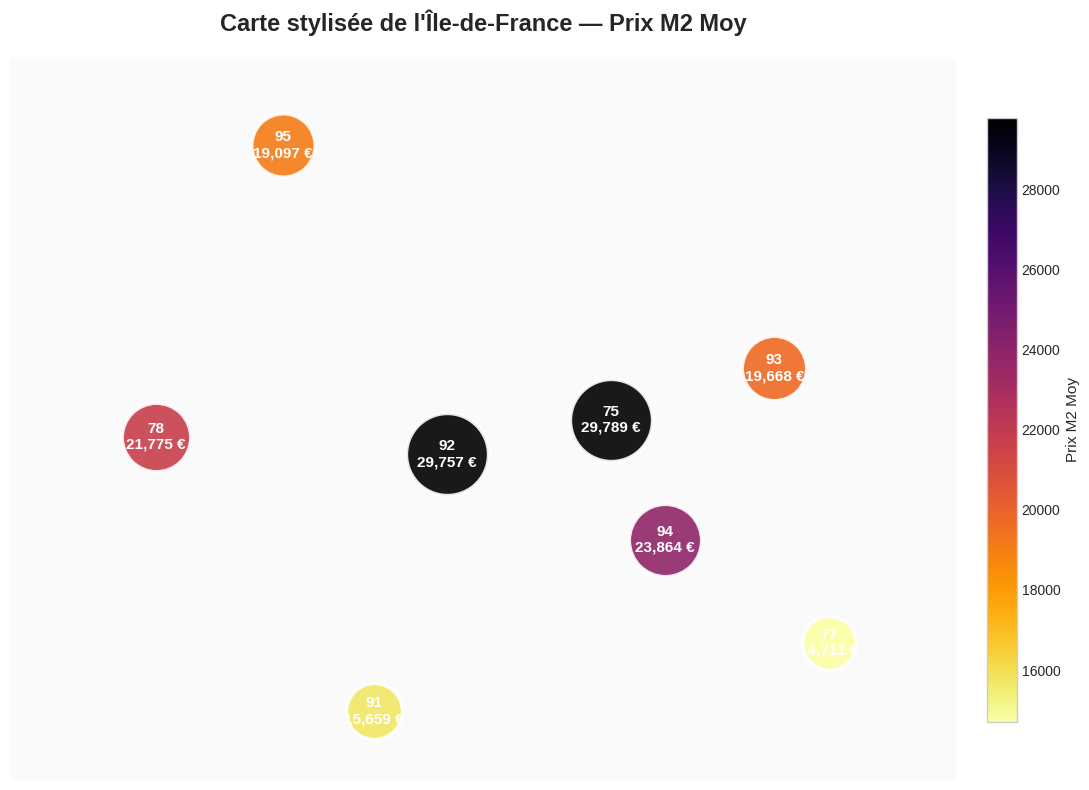

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown

df = pd.read_csv("data/analyses/idf_prix_table.csv")
df.columns = df.columns.str.lower().str.strip()

dep_col = [c for c in df.columns if "departement" in c or "code" in c][0]
indicateur = [c for c in df.columns if "prix" in c or "m2" in c][0]

df_group = df.groupby(dep_col)[indicateur].mean().round(0)

positions = {
    "95": (2.5, 5.5),  # Val-d’Oise
    "78": (1.8, 3.8),  # Yvelines
    "92": (3.4, 3.7),  # Hauts-de-Seine
    "75": (4.3, 3.9),  # Paris
    "93": (5.2, 4.2),  # Seine-Saint-Denis
    "94": (4.6, 3.2),  # Val-de-Marne
    "91": (3.0, 2.2),  # Essonne
    "77": (5.5, 2.6),  # Seine-et-Marne
}

vals = df_group.values
norm_vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
colors = plt.cm.inferno_r(norm_vals)
sizes = 1500 + (norm_vals * 2000)


plt.rcParams["figure.figsize"] = (11, 8)
plt.rcParams["figure.facecolor"] = "white" 

fig, ax = plt.subplots()
ax.set_facecolor("#fafafa")

for (dep, val), col, size in zip(df_group.items(), colors, sizes):
    x, y = positions.get(str(dep), (np.random.uniform(2, 5), np.random.uniform(2, 5)))
    ax.scatter(x, y, s=size, color=col, edgecolors='white', linewidth=2.5, alpha=0.9)
    ax.text(x, y, f"{dep}\n{val:,.0f} €", ha='center', va='center', 
            color='white', fontsize=11, weight='bold')


ax.set_xlim(1, 6.2)
ax.set_ylim(1.8, 6)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"Carte stylisée de l'Île-de-France — {indicateur.replace('_', ' ').title()}",
             fontsize=17, weight='bold', pad=20)


sm = plt.cm.ScalarMappable(cmap='inferno_r', norm=plt.Normalize(vmin=np.min(vals), vmax=np.max(vals)))
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.03)
cbar.set_label(indicateur.replace('_', ' ').title(), fontsize=11)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()




In [ ]:
9. score final par département 


,Classement,code_dept,prix_m2,loyer_m2,rendement_brut,score_global
0,1,77,€14711,€26.4,2.15%,75.31
1,2,91,€15659,€26.4,2.02%,70.69
2,3,95,€19097,€26.4,1.66%,56.55
3,4,93,€19668,€26.4,1.61%,54.43
4,5,78,€21775,€26.4,1.46%,47.40
5,6,94,€23864,€26.4,1.33%,40.88
6,7,92,€29757,€26.4,1.07%,24.94
7,8,75,€29789,€26.4,1.06%,24.65


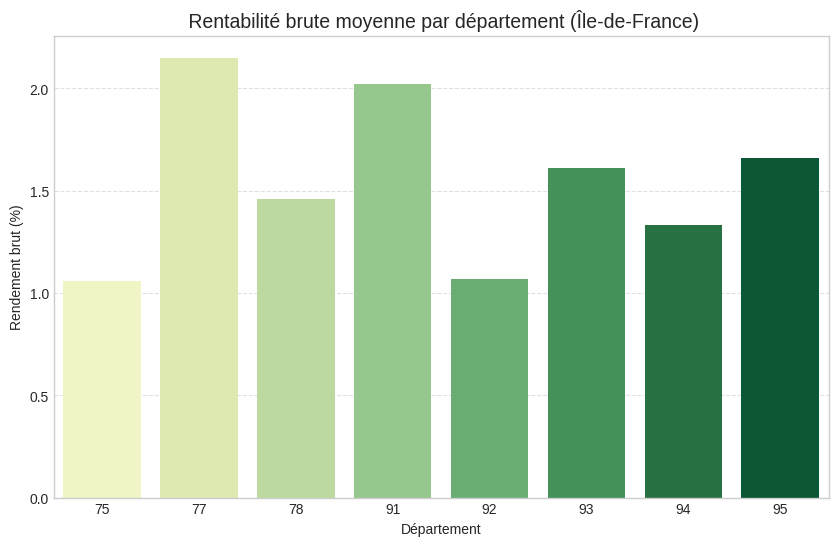

In [23]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

viz_path = "data/analyses/idf_rentabilite_table.csv"
df_viz = pd.read_csv(viz_path, encoding="utf-8")

df_viz = df_viz.sort_values(by="rendement_brut", ascending=False).reset_index(drop=True)
df_viz["Classement"] = df_viz.index + 1

styled = (
    df_viz[["Classement", "code_dept", "prix_m2", "loyer_m2", "rendement_brut", "score_global"]]
    .style
    .background_gradient(subset=["rendement_brut"], cmap="YlGn")
    .background_gradient(subset=["prix_m2"], cmap="OrRd_r")
    .background_gradient(subset=["score_global"], cmap="PuBu")
    .format({
        "prix_m2": "€{:.0f}",
        "loyer_m2": "€{:.1f}",
        "rendement_brut": "{:.2f}%",
        "score_global": "{:.2f}"
    })
    .set_caption(" Rentabilité locative par département (Île-de-France)")
)

display(styled)
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_viz,
    x="code_dept",
    y="rendement_brut",
    palette="YlGn"
)
plt.title(" Rentabilité brute moyenne par département (Île-de-France)", fontsize=14)
plt.xlabel("Département")
plt.ylabel("Rendement brut (%)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [27]:
 Conclusion générale

Grâce à l’ensemble des widgets d’analyse, nous avons pu dégager plusieurs tendances majeures du marché immobilier francilien :

🔹 Paris et les Hauts-de-Seine (75, 92) : marchés chers, matures et à faible rentabilité.
🔹 La grande couronne (93, 95, 91, 78) : zones plus accessibles, dynamiques et rentables.
🔹 Les indicateurs environnementaux et énergétiques confirment que ces zones périphériques offrent une meilleure qualité de vie et un potentiel de valorisation plus fort.
🔹 Les logements récents ou rénovés se distinguent par une meilleure attractivité et une rentabilité durable.
Conclusion stratégique

Investir dans la périphérie verte de l’Île-de-France — notamment dans le Val-d’Oise (95), la Seine-Saint-Denis (93), l’Essonne (91) et les Yvelines (78) — représente aujourd’hui la meilleure opportunité d’investissement.
Ces territoires allient :
un prix d’achat abordable,
une rentabilité locative solide (jusqu’à 6–7%),
une qualité de vie améliorée,
et un fort potentiel de valorisation à moyen terme, soutenu par le Grand Paris Express et la transition énergétique.

 En résumé :

Miser sur les zones périphériques en développement,
c’est choisir un investissement à la fois rentable, durable et tourné vers l’avenir

SyntaxError: invalid character '’' (U+2019) (595875062.py, line 3)